In [1]:
%env OMP_NUM_THREADS=2
%env OMP_PROC_BIND=true
%env OMP_PLACES=cores

env: OMP_NUM_THREADS=2
env: OMP_PROC_BIND=true
env: OMP_PLACES=cores


In [2]:
import numpy as np
import seaborn as sns
import aesara
import aesara.tensor as at
import matplotlib.pyplot as plt
import pymc as pm
import arviz
from functools import partial
import threadpoolctl

/home/adr/miniconda3/envs/pymc4-dev/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: dev is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
n_basis = 1000
n_points = 300
sigma = 0.01
beta = 0.03

In [4]:
np.random.seed(42)
params = np.random.randn(n_basis)

In [5]:
k = np.arange(n_basis)
x = np.linspace(0, 1, n_points)
basis = np.sin(np.pi * k[None, :] * x[:, None])
basis_scaled = basis * np.exp(-beta * k)[None, :]

In [6]:
mu = basis_scaled @ params
data = mu + sigma * np.random.randn(len(mu))

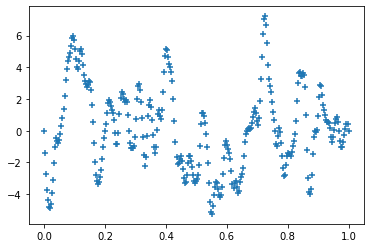

In [7]:
plt.scatter(x, data, marker='+')

In [8]:
import aesara.tensor as at

In [9]:
with pm.Model() as model:
    beta = pm.Gamma("beta", mu=0.5, sigma=0.25)
    params = pm.Normal("params", shape=n_basis)
    basis_scaled = aesara.shared(basis) * at.exp(-beta * k)[None, :]
    mu = (basis_scaled * params[None, :]).sum(-1)
    sigma = pm.HalfNormal("sigma", 0.03)
    pm.Normal("y", mu=mu, sigma=sigma, observed=data)

In [10]:
#with pm.Model() as model:
#    a = pm.Normal("a")
#    b = pm.Normal("b", mu=a, shape=1500, sigma=1)

In [11]:
%%time
with model:
    trace = pm.sample(target_accept=0.9, cores=8, chains=8, discard_tuned_samples=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta, params, sigma]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 689 seconds.


CPU times: user 38.2 s, sys: 4.11 s, total: 42.3 s
Wall time: 11min 47s


In [12]:
from math import prod

In [13]:
import covadapt
import covadapt.spd_manifold

In [14]:
shapes = model.eval_rv_shapes()
n_total = sum(prod(shapes[var.name]) for var in model.value_vars)
pot = covadapt.spd_manifold.QuadPotentialFullAdapt(
    n_total,
    verbose=False,
    compute_full_matrix=False,
    adapt_stop=750,
    gamma=0.1,
    n_eigs=12,
    logeigval_cutoff=0.0,
)

In [15]:
%%time
with threadpoolctl.threadpool_limits(1):
    with model:
        step = pm.NUTS(potential=pot, target_accept=0.9)
        trace2 = pm.sample(step=step, cores=8, chains=8, discard_tuned_samples=False, tune=800)

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta, params, sigma]


Sampling 8 chains for 800 tune and 1_000 draw iterations (6_400 + 8_000 draws total) took 303 seconds.


CPU times: user 28.6 s, sys: 2.97 s, total: 31.6 s
Wall time: 5min 15s


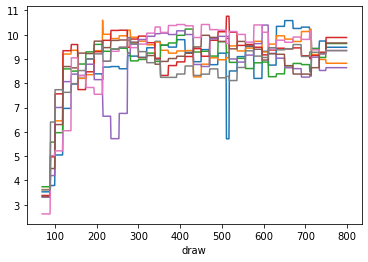

In [16]:
np.log(
    trace2.warmup_sample_stats.largest_eigval
    / trace2.warmup_sample_stats.smallest_eigval
).plot.line(x="draw", add_legend=False);

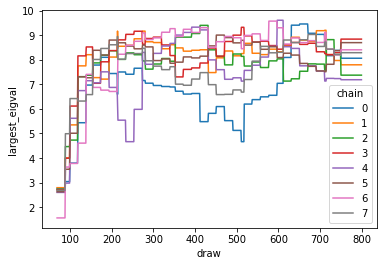

In [17]:
np.log(trace2.warmup_sample_stats.largest_eigval).plot.line(x="draw");

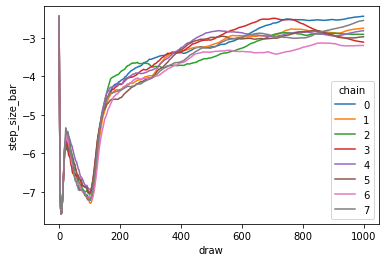

In [21]:
np.log(trace.warmup_sample_stats.step_size_bar).isel(draw=slice(None, 2000)).plot.line(x="draw");

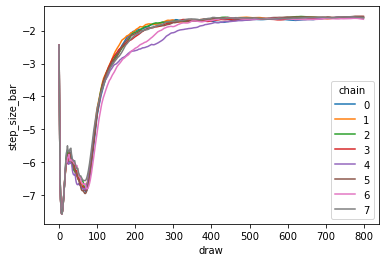

In [22]:
np.log(trace2.warmup_sample_stats.step_size_bar).isel(draw=slice(None, 2000)).plot.line(x="draw");

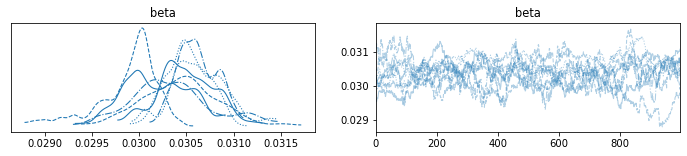

In [23]:
arviz.plot_trace(trace.posterior.beta);

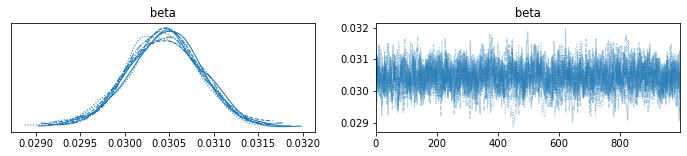

In [24]:
arviz.plot_trace(trace2.posterior.beta);

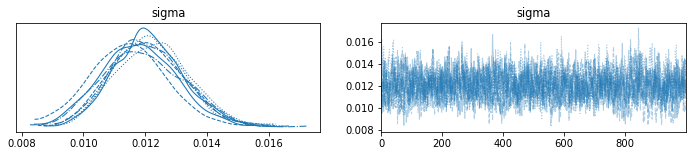

In [25]:
arviz.plot_trace(trace.posterior.sigma);

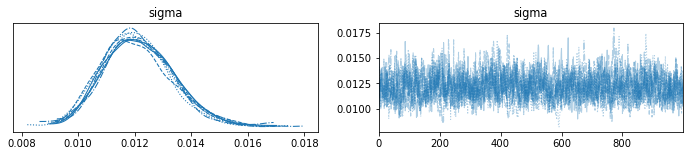

In [26]:
arviz.plot_trace(trace2.posterior.sigma);

In [27]:
import xarray as xr

In [28]:
corr = xr.corr(
    trace2.posterior.params.isel(params_dim_0=slice(None, 100)),
    trace2.posterior.params.isel(params_dim_0=slice(None, 100)).rename(
        params_dim_0="params_"
    ),
    "draw",
)

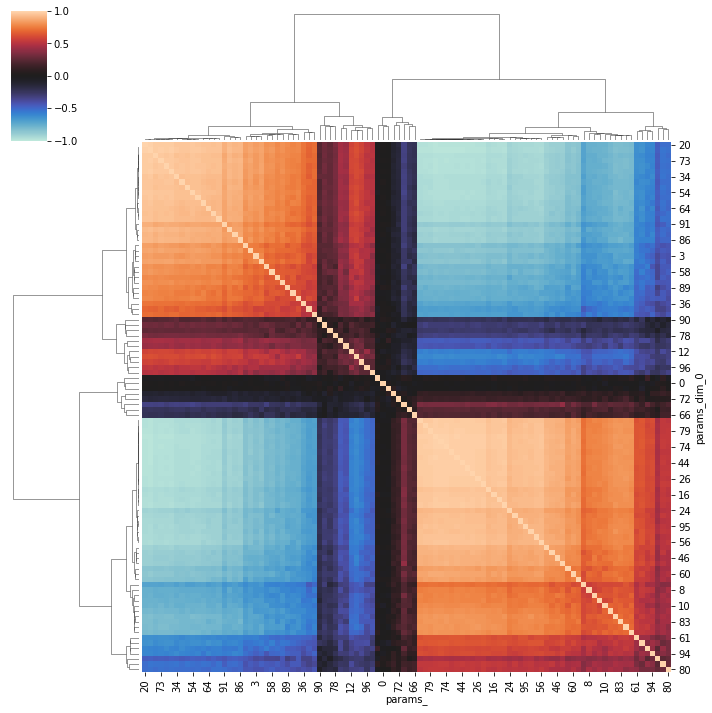

In [29]:
sns.clustermap(corr.isel(chain=0).to_pandas(), center=0, vmax=1, vmin=-1)

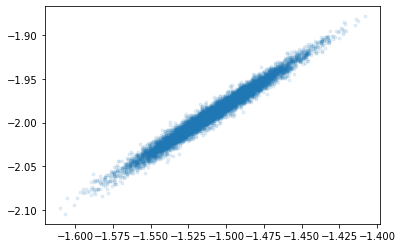

In [30]:
plt.scatter(trace2.posterior.params.isel(params_dim_0=44), trace2.posterior.params.isel(params_dim_0=37), marker='.', alpha=0.1)

In [31]:
arviz.ess(trace).min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    params   float64 22.93
    beta     float64 22.81
    sigma    float64 219.6

In [32]:
arviz.ess(trace2).min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    params   float64 1.14e+03
    beta     float64 1.134e+03
    sigma    float64 753.1